In [1]:
%matplotlib inline
#Import Libraries
import random as rn
import yfinance as yf  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.ticker import MaxNLocator
import py_vollib.black.greeks.analytical as bs #Special Package to calculate deltas - MIT License
import pandasql
from numpy import sqrt,mean,log,diff

In [2]:
class data_download:
    
    def __init__(self, symbol, start_dt, end_dt, option_calendar_days, splits):
        
        self.symbol = symbol
        self.start_dt = start_dt
        self.end_dt = end_dt
        self.data = None
        self.opt_cal_days = option_calendar_days
        self.splits = splits
        self.data_dict = {}
        
    def download(self):
        self.data = yf.download(self.symbol,self.start_dt,self.end_dt)
        
    def generate_splits(self):
        for h in range(1, self.splits):
            self.data_dict[h] = self.data.iloc[self.opt_cal_days*(h-1) : self.opt_cal_days*(h-1)+(self.opt_cal_days-1), 4].values.flatten()


In [3]:
#voo = data_download('VOO','2010-01-01','2019-08-01',62,35)

bnd = data_download('BND','2017-04-17','2020-03-31',62,12)
bnd.download()
bnd.generate_splits()

[*********************100%***********************]  1 of 1 completed


In [4]:
class data_prep:
    
    def __init__ (self, prev_prices, prices, strike_price, state_cut_offs = [0.5, 1.0], time_cut_offs = [3,7],option_length_years = 0.25, risk_free = 0.05, symbol = 'VOO'):
        
        self.symbol = symbol
        self.prices = prices
        self.prev_prices = prev_prices
        self.est_daily_volatility = None
        self.annual_vol = None
        self.strike_price = strike_price
        self.state_cut_offs = state_cut_offs
        self.time_cut_offs = time_cut_offs
        self.option_length = option_length_years
        self.risk_free = risk_free
        self.state_defs = None
    
    def estimate_volatility(self):
        r = diff(log(self.prev_prices))
        r_mean = mean(r)
        diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
        std = sqrt(sum(diff_square)*(1.0/(len(r)-1)))
        self.est_daily_volatility = std #Calculated at Daily Level
        self.annual_vol = self.est_daily_volatility*np.sqrt(252)
    
    def apply_defs(self, p):
        
        extracted_states = []
        
        ll = [[p[0],p[0],0]]

        for i in range(1,len(p)):
            if p[i] == p[i-1]:
                ll.append([p[i],p[i],ll[i-1][2]])
            else:
                ll.append([p[i],p[i-1],i])
                
        flist = []

        for m in range(len(ll)):
            z = [ll[m][0],ll[m][1],m - ll[m][2]]
            flist.append(z)
            
        for item in flist:
            if item[2] >= self.time_cut_offs[1]:
                extracted_states.append([item[0],item[1],'H'])
            else:
                if item[2] < self.time_cut_offs[1] and item[2] >= self.time_cut_offs[0]:
                    extracted_states.append([item[0],item[1],'M'])
                else:
                    extracted_states.append([item[0],item[1],'L'])
            
        self.state_defs = extracted_states
    
    def state_discretizer(self,x):
        
        if x >= self.state_cut_offs[1]:
            return 'H'
        else:
            if x >= self.state_cut_offs[0] and x < self.state_cut_offs[1]:
                return 'M'
            else:
                return 'L'
        
    def load_defs(self):
        
        _states = [self.state_discretizer(p/self.strike_price) for p in self.prices]
        self.apply_defs(_states)
        
                

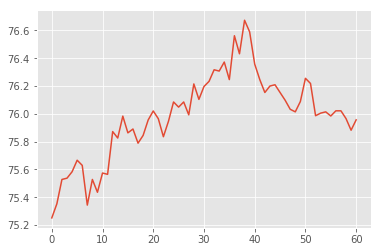

In [5]:
plt.plot(bnd.data_dict[2])

In [6]:
#Load Values
b2 = data_prep(prev_prices=bnd.data_dict[1], prices=bnd.data_dict[2],strike_price=76.000000)
b2.estimate_volatility()
b2.load_defs()

In [7]:
mc_policy = {}

for i in ['H','M','L']:
    for j in ['H','M','L']:
        for k in ['H','M','L']:
                mc_policy[(i,j,k)] = []


In [8]:
class monte_carlo_online2:
     
    def __init__ (self, data_object, num_episodes = 2000, explore_rate=0.20, gamma=1, strategies = [0,1], policy = mc_policy):
            
        self.voo = data_object
        self.num_episodes = num_episodes
        self.explore_rate = explore_rate
        self.gamma = gamma
        self.episodes = None
        self.strategies = strategies
        self.annual_vol = data_object.est_daily_volatility*np.sqrt(252)
        self.policy = policy
        self.global_policy = {}
        self.deltas = None
        self.store_profits = {}
        
    '''
    Define the Q table and Methods
    
    '''   
    
    
    #We use the mean value from Q Value Distribution for scoring on new data.
    def update_avg_values_of_key(self, key_value, new_value):
        self.qsa[key_value] = new_value
    
    #Instead of having a single Q Value, we maintain a distribution of Q Values
    def update_values_of_keys_dist(self, key_value, new_value):
        self.qsa_dist[key_value].append(new_value)
    
    #As we run through the episodes, we keep adding the new Q Values to create a more robust distribution
    def append_value_of_keys(self, key_value, new_value):
        
        if key_value in self.qsa_dist.keys():
            self.update_values_of_keys_dist(key_value, new_value)
        else:
            self.qsa_dist[key_value] = [new_value]
            
    def update_qvalue_avg_all(self):
        for key_value in self.qsa_dist:
            if len(self.qsa_dist[key_value]) > 0:
                self.update_avg_values_of_key(key_value, np.mean(self.qsa_dist[key_value]))
    
    #This method allows us to reuse already learnt Q Table for another time period in future
    def return_qdicts(self):
        return self.qsa, self.qsa_dist
        
    
    #This method plots the distribution of Q values.
    def qsa_dist_mc_plot(self, key):
        plt.hist(self.qsa_dist[(key[0],key[1],key[2],0)], alpha=0.5, label='Action = 0')
        plt.hist(self.qsa_dist[(key[0],key[1],key[2],1)], alpha=0.5, label='Action = 1')
        plt.legend(loc='upper right')
        plt.ylabel(r'Distribition of $Returns$')
        plt.title('Distribution of Optimal Returns for Q(s,a) = ' + str(key))
        plt.show()
        
        
        
    '''
    Define the Montecarlo Algorithm
    '''   
    
    #This method calculates the Black Scholes delta for each option path.
    def delta(self):
        self.deltas =  [np.around(bs.delta('c',self.voo.prices[h], 
                          self.voo.strike_price, 
                          self.voo.option_length - np.around(h/252,2), #Time to expiry
                          self.voo.risk_free, 
                          self.annual_vol),2) for h in range(len(self.voo.prices))]
        
    def profit_function(self, episode):
    
        positions = [self.deltas[h] if episode[h] == 1 else self.deltas[h-1] for h in range(len(self.voo.prices))]
    
        #Cost of Borrowing Money for 1 day 
        dollar_positions = -1*[self.voo.prices[h]*positions[h]*self.voo.risk_free for h in range(len(self.voo.prices))]
    
        #Cost of adjusting portfolio to bring position at par with BS delta
        portfolio_positions = [self.voo.prices[h]*(positions[h] - positions[h-1]) for h in range(1,len(self.voo.prices))]
    
        #Sum daily transaction costs over the Option Time Frame
        transaction_cost = sum(dollar_positions)
    
        #Sum daily portfolio costs over the Option Time Frame
        portfolio_cost = sum(portfolio_positions)
    
        #Return the Excess Profit over Black Scholes
        return transaction_cost + portfolio_cost
    
    
    #This is the Monte Carlo episode generator. For each episode, randomly picks action along the option path.
    def generate_episodes(self):
        
        self.episodes = [[rn.choice(self.strategies) for day in range(len(self.voo.prices))] for episode in range(self.num_episodes)]
    
    
    #New Code.
    
    def sort_tuple(self, tup):
        tup.sort(key = lambda x: x[1])  
        return tup  
      
    def top_episode_profits(self, top_count):
        
        to_sort = [(e, self.profit_function(self.episodes[e])) for e in range(len(self.episodes))]
        top_eps = self.sort_tuple(to_sort)[-top_count:]
        ep_index_top = [seq[0] for seq in top_eps]
        return ep_index_top
    
    def insert_states(self, key_value, new_value):
        if key_value in self.policy.keys():
            self.policy[key_value].append(new_value)
        else:
            self.policy[key_value] = new_value
            
    def discretize(self, continous_val):
        if continous_val >= 0.5:
            return 1
        else:
            return 0
    
    def get_global_policy(self):
        
        #Most Granular Policy
        
        ideal_pol = []
        
        idxs = self.top_episode_profits(100)
        
        for day in range(len(self.voo.prices)):
            ideal_pol.append(np.mean([self.episodes[idx][day] for idx in idxs]))
            
        #Append States
        
        for day in range(len(self.voo.prices)):
            self.insert_states((self.voo.state_defs[day][0],self.voo.state_defs[day][1],self.voo.state_defs[day][2]),ideal_pol[day])
            
        #Update Global Policy Table
        
        for i in ['H','M','L']:
            for j in ['H','M','L']:
                for k in ['H','M','L']:
                    if (i,j,k) in self.policy.keys():
                        if self.policy[(i,j,k)] != []:
                            self.global_policy[(i,j,k)] = self.discretize(np.mean(self.policy[(i,j,k)]))
                        else:
                            self.global_policy[(i,j,k)] = []
        

In [9]:
P_alt = monte_carlo_online2(data_object=b2)
P_alt.delta()
P_alt.generate_episodes()
P_alt.get_global_policy()

In [13]:
class mc_online_predict:
    
    def __init__ (self, data_object, policy, epsilon, strategies):
        
        self.data_object = data_object
        self.policy = policy
        self.epsilon = epsilon
        self.strategies = strategies
        self.greedy_episode = None
        self.epsilon_episode = None
        self.deltas = None
        self.ada_eps_episode = None
        
    def delta(self):
        self.deltas =  [np.around(bs.delta('c',self.data_object.prices[h], 
                          self.data_object.strike_price, 
                          self.data_object.option_length - np.around(h/252,2), #Time to expiry
                          self.data_object.risk_free, 
                          self.data_object.annual_vol),2) for h in range(len(self.data_object.prices))]
        
    def print_params(self):
        print(self.data_object.prices)
        print(self.epsilon_episode)
        print(self.deltas)
        
    #Here episode represents whether strategy = 0 or 1
    def predict_profit_function(self, episode):
    
        positions = [self.deltas[h] if episode[h] == 1 else self.deltas[h-1] for h in range(len(self.data_object.prices))]
    
        #Cost of Borrowing Money for 1 day 
        dollar_positions = -1*[self.data_object.prices[h]*positions[h]*self.data_object.risk_free for h in range(len(self.data_object.prices))]
    
        #Cost of adjusting portfolio to bring position at par with BS delta
        portfolio_positions = [self.data_object.prices[h]*(positions[h] - positions[h-1]) for h in range(1,len(self.data_object.prices))]
    
        #Sum daily transaction costs over the Option Time Frame
        transaction_cost = sum(dollar_positions)
    
        #Sum daily portfolio costs over the Option Time Frame
        portfolio_cost = sum(portfolio_positions)
    
        #Return the Excess Profit over Black Scholes
        return transaction_cost + portfolio_cost
    
    def bs_profit(self):
        
        positions = [self.deltas[h] for h in range(len(self.data_object.prices))]
    
        #Cost of Borrowing Money for 1 day 
        dollar_positions = -1*[self.data_object.prices[h]*positions[h]*self.data_object.risk_free for h in range(len(self.data_object.prices))]
    
        #Cost of adjusting portfolio to bring position at par with BS delta
        portfolio_positions = [self.data_object.prices[h]*(positions[h] - positions[h-1]) for h in range(1,len(self.data_object.prices))]
    
        #Sum daily transaction costs over the Option Time Frame
        transaction_cost = sum(dollar_positions)
    
        #Sum daily portfolio costs over the Option Time Frame
        portfolio_cost = sum(portfolio_positions)
    
        #Return the Excess Profit over Black Scholes
        return transaction_cost + portfolio_cost
    
        
    def mc_predict_greedy(self):
        
        episode = [self.policy[(state_def[0],state_def[1],state_def[2])] for state_def in self.data_object.state_defs]
        
        self.greedy_episode = episode
        
        return(self.data_object.predict_profit_function(self.greedy_episode))
        
    
    def mc_predict_with_explore(self):
        episode = [self.policy[(state_def[0],state_def[1],state_def[2])] 
                       if np.random.uniform(0,1,1) >= self.epsilon else rn.choice(self.strategies) 
                           for state_def in self.data_object.state_defs]
        
        self.epsilon_episode = episode
        
        return(self.predict_profit_function(self.epsilon_episode))
    
    
    def mc_predict_with_explore2(self):
        
        learnt_episode = []
        
        for state_def in self.data_object.state_defs:
            if self.policy[(state_def[0],state_def[1],state_def[2])] != []:
                
                if np.random.uniform(0,1,1) >= self.epsilon:
                    learnt_episode.append(self.policy[(state_def[0],state_def[1],state_def[2])])
                else:
                    learnt_episode.append(rn.choice(self.strategies))
                    
            else:
                learnt_episode.append(rn.choice(self.strategies))
            
            
        self.epsilon_episode = learnt_episode
        
        return(self.predict_profit_function(self.epsilon_episode))
    
    
    def mc_predict_explore_adaptive(self):
                
        episode = [self.policy[(state_def[0],state_def[1],state_def[2])] 
                       if np.random.uniform(0,1,1) >= self.epsilon*np.exp(-1.00*idx/62) else rn.choice(self.strategies) 
                           for state_def, idx in enumerate(self.data_object.state_defs)]
        
        self.ada_eps_episode = episode
        
        return(self.predict_profit_function(self.ada_eps_episode))
    
    '''
    To be Coded
    '''
    def plot_profit(self, episode_profits):
        plt.hist(episode_profits, facecolor='orange', alpha=0.5)
        plt.show()
    
    
    #This generates the strategy plot for a new time period.
    def plot_policy(self, ptype):
        
        ep = [j if j != [] else 0 for j in self.epsilon_episode]
        
        ptypes = {'g':'Greedy', 'e':'Epsilon', 'a':'Adpative'}

        fig = plt.figure(figsize=(15,7.5))
        ax1 = fig.add_subplot(111)
        ax1.plot(self.data_object.prices)
        ax1.set_ylabel(r'Spot Price $(S_t)$')
        ax1.set_xlabel('Days')
        plt.title(r'Best Chosen Actions by the ' + ptypes[ptype] + ' Algorithm by Day for $'+ 'BND' +'$')
        ax2 = ax1.twinx()
        
        if ptype == 'g':
            ax2.plot(self.greedy_episode,'b-')
        else:
            if ptype == 'e':
                ax2.plot(ep,'b-')
            else:
                ax2.plot(self.ada_eps_episode,'b-')
                
        ax2.set_ylabel('Choosen Action', color = 'b')
        ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
        for tl in ax2.get_yticklabels():
            tl.set_color('b')

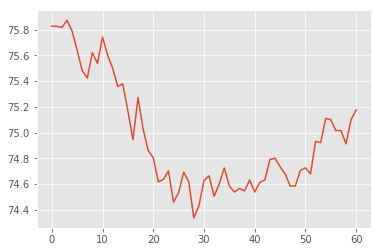

In [11]:
plt.plot(bnd.data_dict[4])

In [11]:
bnd.symbol

'BND'

-31.52576065063477
-31.526046142578128


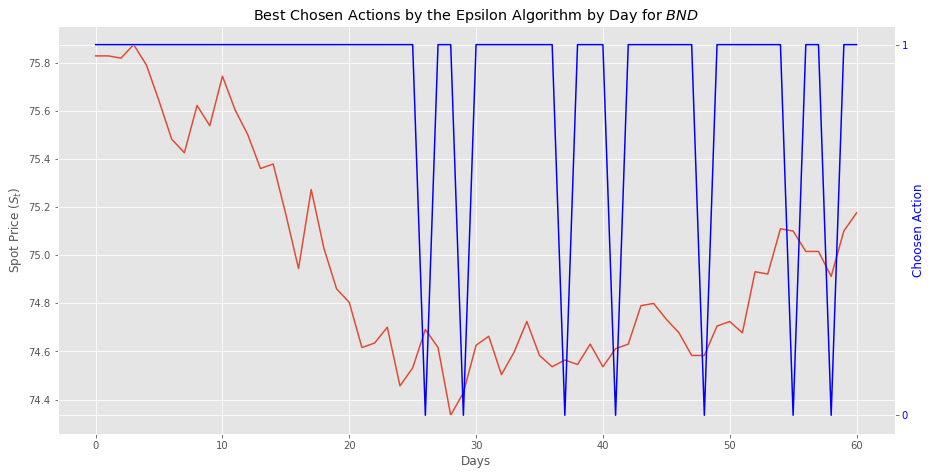

In [14]:
b4 = data_prep(prev_prices=bnd.data_dict[3], prices=bnd.data_dict[4],strike_price=76.000000)
b4.estimate_volatility()
b4.load_defs()

#Use the learnt Policy Dictionary
pol = P_alt.global_policy

#Epsilon
eps = 0.20

#strategies
strat = [0,1]

#Predict
B4 = mc_online_predict(b4,pol,eps,strat)
B4.delta()
print(B4.mc_predict_with_explore())
print(B4.bs_profit())
#M4.print_params()

#Plot
B4.plot_policy(ptype = 'e')


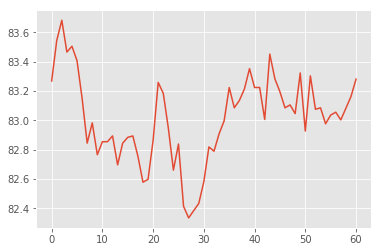

In [14]:
plt.plot(bnd.data_dict[11])

-24.674165649414054
-26.328606185913088


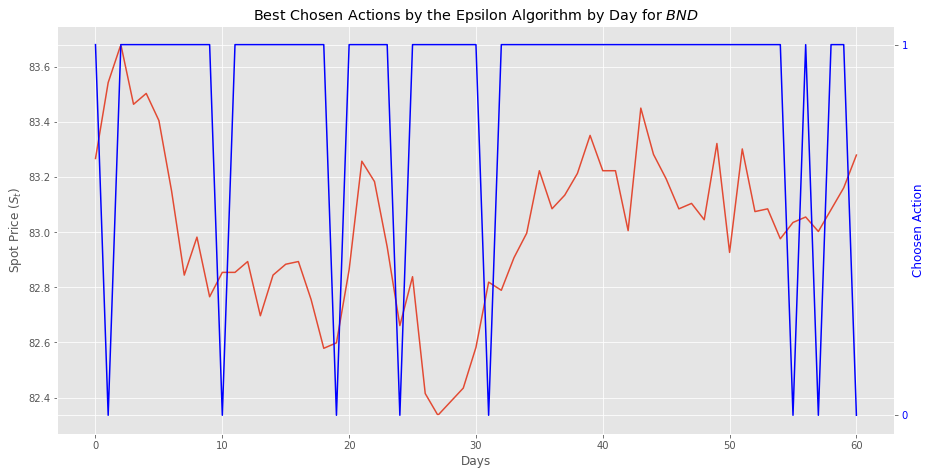

In [15]:
b12 = data_prep(prev_prices=bnd.data_dict[10], prices=bnd.data_dict[11],strike_price=84.000000)
b12.estimate_volatility()
b12.load_defs()

#Use the learnt Policy Dictionary
pol = P_alt.global_policy

#Epsilon
eps = 0.20

#strategies
strat = [0,1]

#Predict
B12 = mc_online_predict(b12,pol,eps,strat)
B12.delta()
print(B12.mc_predict_with_explore())
print(B12.bs_profit())

#Plot
B12.plot_policy(ptype = 'e')


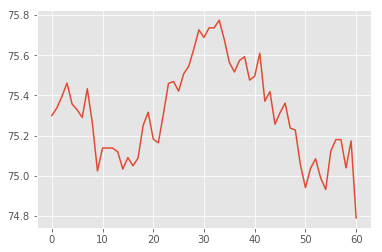

In [13]:
plt.plot(bnd.data_dict[6])

-20.249632110595705
-20.2454411315918


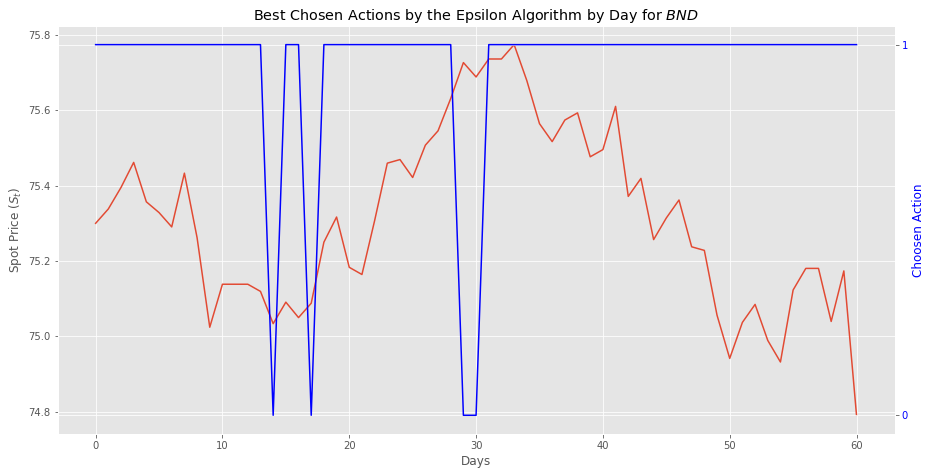

In [17]:
b6 = data_prep(prev_prices=bnd.data_dict[5], prices=bnd.data_dict[6],strike_price=76.000000)
b6.estimate_volatility()
b6.load_defs()

#Use the learnt Policy Dictionary
pol = P_alt.global_policy

#Epsilon
eps = 0.20

#strategies
strat = [0,1]

#Predict
B6 = mc_online_predict(b6,pol,eps,strat)
B6.delta()
print(B6.mc_predict_with_explore())
print(B6.bs_profit())

#Plot
B6.plot_policy(ptype = 'e')


In [19]:
class call_option:
    
    def __init__(self, symbol, closing_prices, maturity_price, maturity_time_years = 0.25, risk_free_yearly = 0.05, trading_days_yearly = 252):
        
        self.symbol = symbol
        self.closing_prices = closing_prices
        self.maturity_price = maturity_price
        self.maturity_time_years = maturity_time_years
        self.risk_free_yearly = risk_free_yearly
        self.trading_days_yearly = trading_days_yearly
        
        self.mu_day = None
        self.std_day = None
        self.mean_line = None
        self.upper_error_bound = None
        self.lower_error_bound = None
        self.deltas = None
        self.states = None
    
    def volatility(self):
        r = diff(log(self.closing_prices))
        r_mean = mean(r)
        diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
        std = sqrt(sum(diff_square)*(1.0/(len(r)-1)))
        return std #Calculated at Daily Level

    def opt_mean(self):
        r = diff(log(self.closing_prices))
        r_mean = mean(r)
        return r_mean


    def daily_return(self):
        returns = []
        for i in range(0, len(self.closing_prices)-1):
            today = self.closing_prices[i+1]
            yesterday = self.closing_prices[i]
            daily_return = (today - yesterday)/yesterday
            returns.append(daily_return)
        return returns


    def set_key_params(self):
        self.mu_day = self.opt_mean()
        self.std_day = self.volatility()
        self.mean_line = [ self.closing_prices[0]*(1+self.mu_day*h) for h in range(0, len(self.closing_prices)) ]
        self.upper_error_bound = [ self.mean_line[h] + self.closing_prices[0]*self.std_day*np.sqrt(h) for h in range(0, len(self.closing_prices)) ]
        self.lower_error_bound = [ self.mean_line[h] - self.closing_prices[0]*self.std_day*np.sqrt(h) for h in range(0, len(self.closing_prices)) ]
        
        
    def generate_plot(self, locs):
        plt.plot(self.closing_prices, label='Price')
        plt.plot(self.mean_line, label='Mean Estimated Price')
        plt.plot(self.upper_error_bound, label='Upper Estimated Bound')
        plt.plot(self.lower_error_bound, label='Lower Estimated Bound')
        plt.legend(loc=locs)
        plt.ylabel(r'Spot Price $(S_t)$')
        plt.xlabel(r'Time in Days $(t)$')
        plt.title('Geometric Brownian Motion for '+ self.symbol)
        plt.show()
    

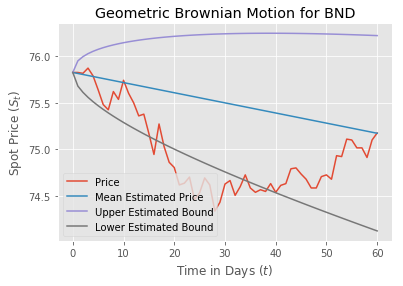

In [21]:
H = call_option(symbol='BND', closing_prices=bnd.data_dict[4], maturity_price=233)
H.set_key_params()
H.generate_plot(locs = 'lower left')

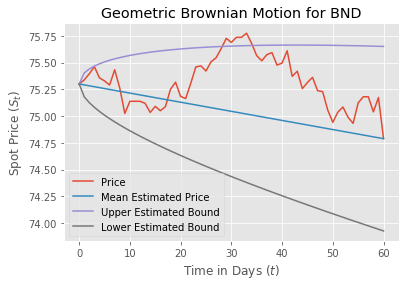

In [22]:
H = call_option(symbol='BND', closing_prices=bnd.data_dict[6], maturity_price=233)
H.set_key_params()
H.generate_plot(locs = 'lower left')

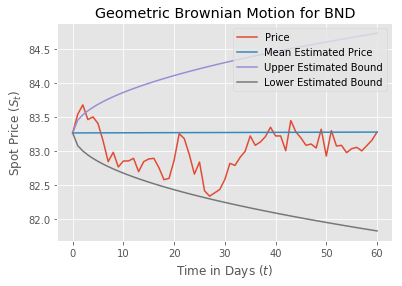

In [24]:
H = call_option(symbol='BND', closing_prices=bnd.data_dict[11], maturity_price=233)
H.set_key_params()
H.generate_plot(locs = 'upper right')